#PRICE PREDICTION FOR LELE (ECERAN)

##Import Some Modules

In [ ]:
import csv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from dataclasses import dataclass

#if importing csv from google drive
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#Load dataset
df1 = pd.read_csv('LeleInputForecastEcer.csv', sep =',')

#PREPROCESSING

##Taking Data

In [ ]:
def get_data(data):
    
    times = []
    value = []

    i = 0
    for row in data:
      times.append(i)
      value.append(float(row)/1000)
      i+=1

    
    return times, value

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    FILE_CSV = 'LeleInputForecastEcer.csv'
    times, price = get_data(df1['Harga'])
    TIME = np.array(times)
    SERIES = np.array(price)
    SPLIT_TIME = 90
    WINDOW_SIZE = 12
    BATCH_SIZE = 12
    SHUFFLE_BUFFER_SIZE = 10


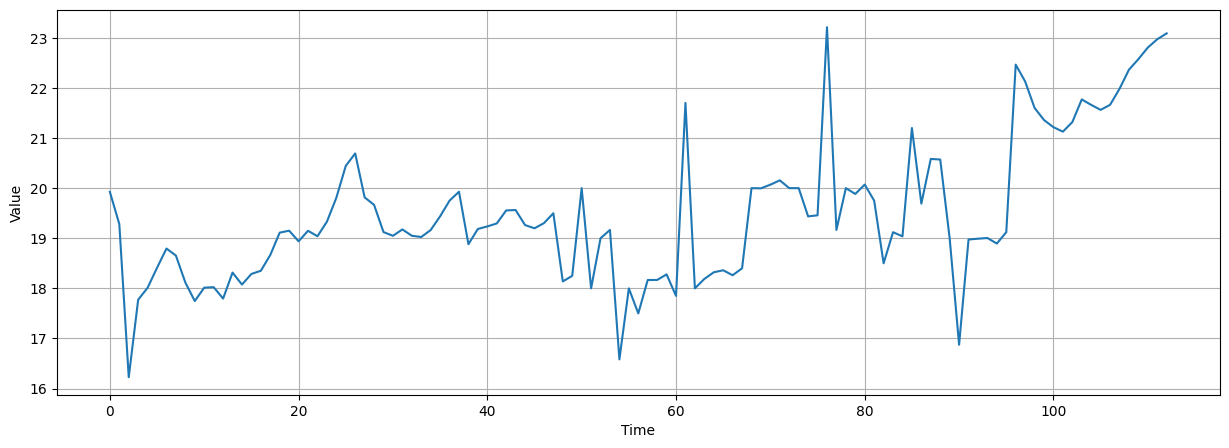

In [ ]:
plt.figure(figsize=(15, 5))
plot_series(G.TIME, G.SERIES)
plt.show()

In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

In [ ]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


In [ ]:
# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

#BUILD THE MODEL

The code snippet provided defines a function `create_model()` that creates a sequential model using the Keras API in TensorFlow. The model architecture is designed for time series forecasting or sequence prediction tasks. Here's a breakdown of the layers in the model:

1. Conv1D layer: This layer performs a 1-dimensional convolution operation on the input data. It uses 32 filters with a kernel size of 3, applying the "causal" padding to preserve the temporal ordering of the sequence. The activation function used is ReLU.

2. Bidirectional LSTM layers: These layers consist of two LSTM (Long Short-Term Memory) layers stacked together, with one processing the input sequence in a forward direction and the other in a backward direction. This allows the model to capture both past and future context information. The LSTM layers have 32 units and return sequences.

3. Dense layers: There are one dense layers in the model. The dense layer has 1 unit, which is the output layer of the model.

4. Lambda layer: The lambda layer applies a scaling operation on the output of the model. It multiplies the output by 100, potentially to rescale the predictions based on the specific problem or desired range.

After defining the model architecture, the `create_model()` function returns the created model. Then, the `model.summary()` function is called to display a summary of the model's architecture, including the layer types, output shapes, and number of parameters. This summary provides a useful overview of the model's structure and can help in verifying that the model is constructed as intended.

In [ ]:
def create_model():
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[G.WINDOW_SIZE, 1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100)
    ]) 

    return model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12, 32)            128       
                                                                 
 bidirectional (Bidirectiona  (None, 12, 64)           16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 41,665
Trainable params: 41,665
Non-traina

In [ ]:
# Test your uncompiled model
uncompiled_model = create_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

7/7 [==============================] - 6s 106ms/step
Your current architecture is compatible with the windowed dataset! :)


Finding the best learning rate:

In [ ]:
# Get initial weights
init_weights = model.get_weights()

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
7/7 [==============================] - 20s 86ms/step - loss: 35.9053 - lr: 1.0000e-08
Epoch 2/100
7/7 [==============================] - 1s 72ms/step - loss: 35.7053 - lr: 1.1220e-08
Epoch 3/100
7/7 [==============================] - 1s 96ms/step - loss: 35.3738 - lr: 1.2589e-08
Epoch 4/100
7/7 [==============================] - 0s 44ms/step - loss: 34.9504 - lr: 1.4125e-08
Epoch 5/100
7/7 [==============================] - 0s 29ms/step - loss: 34.4498 - lr: 1.5849e-08
Epoch 6/100
7/7 [==============================] - 0s 23ms/step - loss: 33.8752 - lr: 1.7783e-08
Epoch 7/100
7/7 [==============================] - 0s 27ms/step - loss: 33.2234 - lr: 1.9953e-08
Epoch 8/100
7/7 [==============================] - 0s 23ms/step - loss: 32.4872 - lr: 2.2387e-08
Epoch 9/100
7/7 [==============================] - 0s 22ms/step - loss: 31.6576 - lr: 2.5119e-08
Epoch 10/100
7/7 [==============================] - 0s 26ms/step - loss: 30.7233 - lr: 2.8184e-08
Epoch 11/100
7/7 [==========

(1e-08, 0.001, 0.0, 50.0)

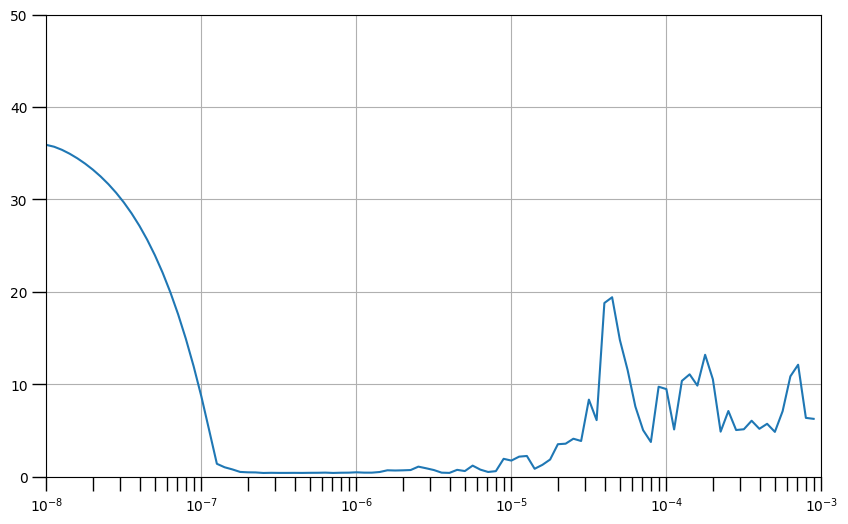

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

Based on the graph above, the recommended learning rate is 1e-6

In [ ]:
# Set the learning rate
learning_rate = 1e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Train the model
Epochs = 200
history = model.fit(train_set,epochs=Epochs)

Epoch 1/200
7/7 [==============================] - 11s 28ms/step - loss: 32.3417 - mae: 32.8417
Epoch 2/200
7/7 [==============================] - 0s 22ms/step - loss: 12.6076 - mae: 13.1014
Epoch 3/200
7/7 [==============================] - 0s 41ms/step - loss: 7.4185 - mae: 7.9185
Epoch 4/200
7/7 [==============================] - 0s 43ms/step - loss: 4.2463 - mae: 4.7237
Epoch 5/200
7/7 [==============================] - 0s 40ms/step - loss: 3.2998 - mae: 3.7818
Epoch 6/200
7/7 [==============================] - 0s 41ms/step - loss: 1.6290 - mae: 2.0932
Epoch 7/200
7/7 [==============================] - 0s 40ms/step - loss: 0.6438 - mae: 1.0601
Epoch 8/200
7/7 [==============================] - 0s 30ms/step - loss: 0.5838 - mae: 0.9776
Epoch 9/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5069 - mae: 0.8976
Epoch 10/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4142 - mae: 0.7748
Epoch 11/200
7/7 [==============================] - 0s 21ms/step

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

#EVALUATE THE MODEL

In [ ]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [ ]:
cnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE, G.BATCH_SIZE).squeeze()
cnn_forecast = cnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]
mse, mae = compute_metrics(series_valid, cnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

9/9 [==============================] - 0s 17ms/step
mse: 3.27, mae: 1.56 for forecast


MAE: 1.56 implies that, on average, the forecast's distance from the true value is 1.56 (Rp1560,00)

9/9 [==============================] - 0s 16ms/step


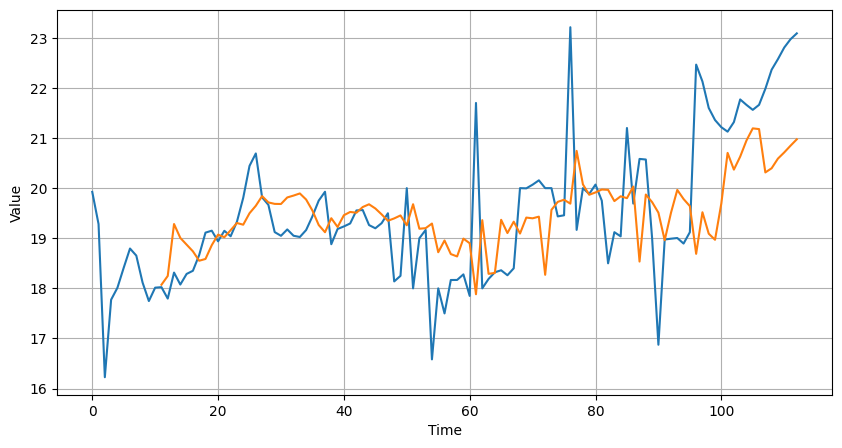

In [ ]:
# Compute the forecast for all the series
cnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE, G.BATCH_SIZE).squeeze()
tam = [None,None,None,None,None,None,None,None,None,None,None]


# Slice the forecast to get only the predictions for the validation set
# cnn_forecast = cnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]
cnn_forecast = np.insert(cnn_forecast, 0, tam)

# Plot the forecast
plt.figure(figsize=(10, 5))
plot_series(G.TIME, G.SERIES)
plot_series(G.TIME, cnn_forecast)

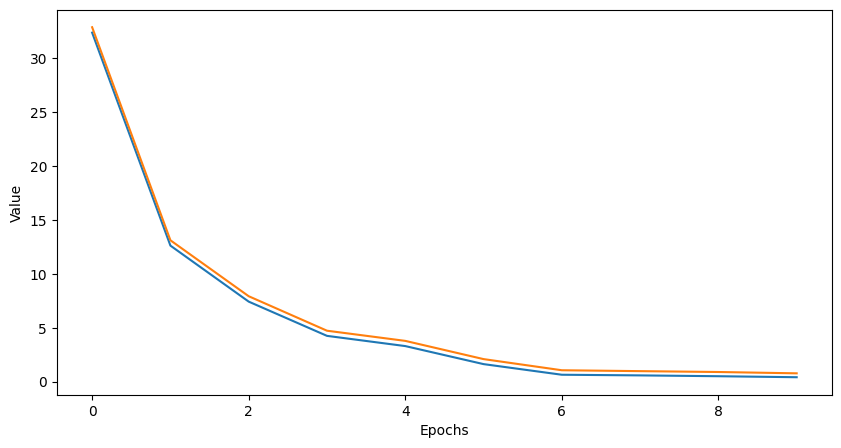

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(10), history.history["loss"][:10])
plt.plot(range(10), history.history["mae"][:10])
plt.xlabel("Epochs")
plt.ylabel("Value")

plt.show()

#FORECASTING

In [ ]:
# prepare data for forecasting
last_window = G.SERIES[-G.WINDOW_SIZE:]
last_window = np.reshape(last_window, (1, G.WINDOW_SIZE, 1))

# make a forecast for n steps ahead
forecast_norm = []
for _ in range(3):
    pred = model.predict(last_window)[0, 0]
    forecast_norm.append(pred)
    last_window = np.roll(last_window, -1, axis=1)
    last_window[0, -1, 0] = pred

forecast = forecast_norm
print("Forecast:", forecast)

1/1 [==============================] - 0s 42ms/step
Forecast: [20.974813, 21.10464, 20.75361]


#SAVING MODEL

In [ ]:
model.save("LelewithForecastedDataEcer.h5")